# $$Seminar 1$$

In [7]:
using TestImages, Images, ImageShow

In [2]:
"""
    my_show(arr::AbstractArray{<:Real}; set_one=false, set_zero=false)
Displays a real valued array . Brightness encodes magnitude.
Works within Jupyter and Pluto.
## Keyword args
* `set_one=false` divides by the maximum to set maximum to 1
* `set_zero=false` subtracts the minimum to set minimum to 1
"""
function my_show(arr::AbstractArray{<:Real}; set_one=true, set_zero=false)
    arr = set_zero ? arr .- minimum(arr) : arr
    arr = set_one ? arr ./ maximum(arr) : arr
    Gray.(arr)
end

my_show

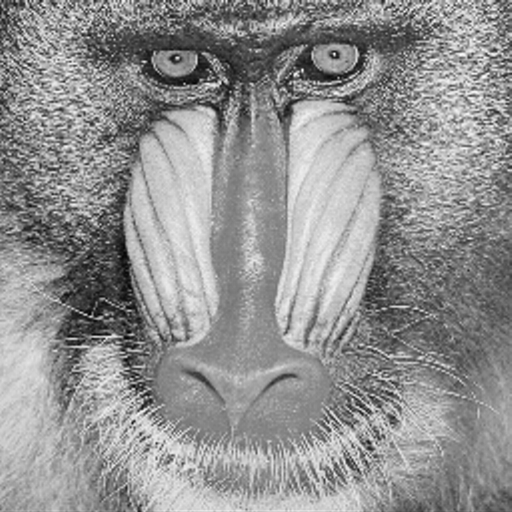

In [8]:
begin
	img = Float64.(testimage("mandril_gray"))
	my_show(img)
end

## **Add Gaussian Noise**

In [1]:
"""
	add_gauss_noise(img, σ=1)

This function adds normal distributed noise to `img`.
`σ` is an optional argument
"""
#=
function add_gauss_noise(img, σ=one(eltype(img)))
	for i in 1:length(img)
		img[i] += σ * randn()
	end
	return img
end		
=#

function add_gauss_noise(img, σ=one(eltype(img)))
	img = img .+ σ .* randn(size(img))
	return img
end	

add_gauss_noise (generic function with 2 methods)

ATTENTION:

Using for loop to add Gaussian noise is different from matrix adding due because `randn(size(img))` creates a Gaussian array, but the loop add Gaussian noise one by one. The latter one is more efficient.

In [10]:
"""
	add_gauss_noise_fl!(img, σ=1)

This function adds normal distributed noise to `img`.
`σ` is an optional argument.
This function is memory efficient by using for loops.


`!` means that the input (`img`) is modified.
Therefore, don't return a new array but instead modify the existing one!
The bang (!) is a convention in Julia that a function modifies the input.
"""
function add_gauss_noise_fl!(img, σ=1)
	img = img .+ σ .* randn(size(img))
end

add_gauss_noise_fl!

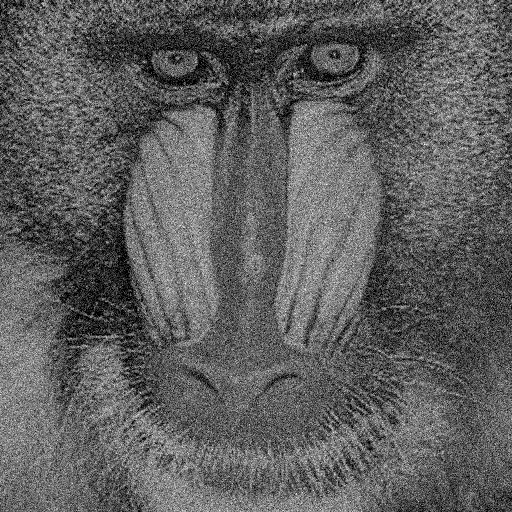

In [11]:
my_show(add_gauss_noise(img, 0.15), set_one=true)

## **Add Poisson Noise**

In microscopy and low light imaging situation, the dominant noise term is usually Poisson noise which we want to simulate here.

In [12]:
using PoissonRandom

In [13]:
"""
	add_poisson_noise!(img, scale_to=nothing)

This function adds poisson distributed noise to `img`.

Before adding noise, it scales the maximum value to `scale_to` and 
divides by it afterwards.
With that we can set the number of events (like a photon count).

Differently said: the `scale_to` applies Noise to an array equivalent to the noise level of an array with maximum peak `scale_to`.

If `isnothing(scale_to) == true`, we don't modify/scale the array.

`!` means that the input is modified.
"""
function add_poisson_noise!(img, scale_to=nothing)
	if isnothing(scale_to)	
		for i in eachindex(img)
			img[i] = pois_rand(img[i])
		end
		return img
	else
		img .= img .* scale_to ./ maximum(img)  
		for i in eachindex(img)
			img[i] = pois_rand(img[i])
		end
		img = img ./ scale_to
		return img
	end
end

add_poisson_noise!

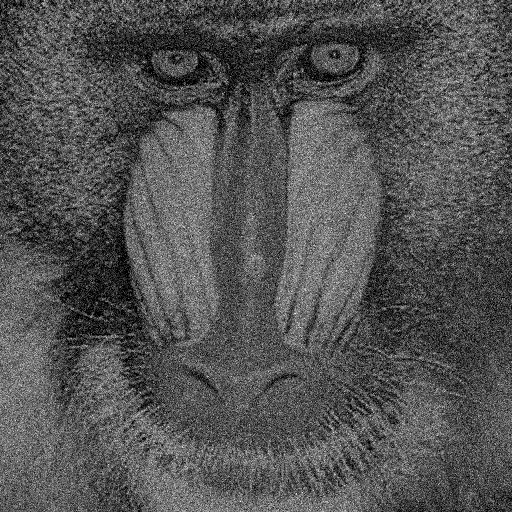

In [14]:
my_show(add_poisson_noise!(100 .* img), set_one=true)

## **Add Hot Pixels**

Another issue are hot pixels which result in a pixel with maximum value. This can be due to damaged pixels or some other noise (radioactivity, ...). Often this is called Salt (because of the maximum brightness) noise.

In [15]:
"""
	add_hot_pixels!(img, probability=0.1; max_value=one(eltype(img)))

Add randomly hot pixels. The probability for each pixel to be hot,
should be specified by `probability`.
`max_value` is a keyword argument which is the value the _hot_ pixel will have.
"""
function add_hot_pixels!(img, probability=0.1; max_value=1)
	img = img ./ maximum(img)
	for i in eachindex(img)
		if rand() < probability
			img[i] = max_value
		end
	end
	return img
end

add_hot_pixels!

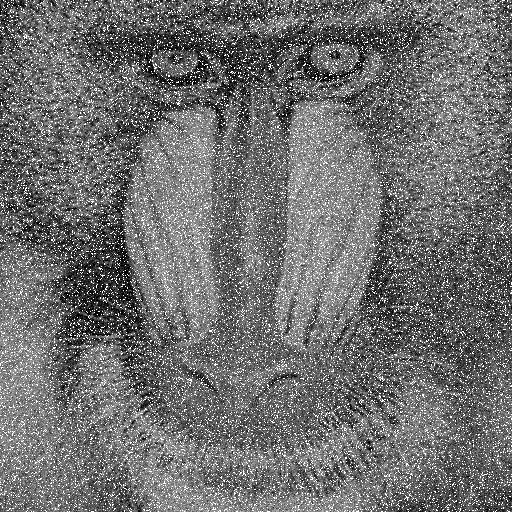

In [16]:
my_show(add_hot_pixels!(copy(img)))

## **Remove Noise From Images**

One option to remove noise is, is to blur the image with a Gaussian kernel. We can convolve a small gaussian (odd sized) Kernel over the array. For that we are using `ImageFiltering.imfilter` for the convolution.

To create a Gaussian shaped function, checkout `IndexFunArrays.normal`. You probably want to normalize the sum of it again

In [20]:
using ImageFiltering, IndexFunArrays

In [18]:
begin
	img_g = add_gauss_noise(img, 0.1)
	img_p = add_poisson_noise!(100 .* copy(img)) ./ 100
	img_h = add_hot_pixels!(copy(img))
end;

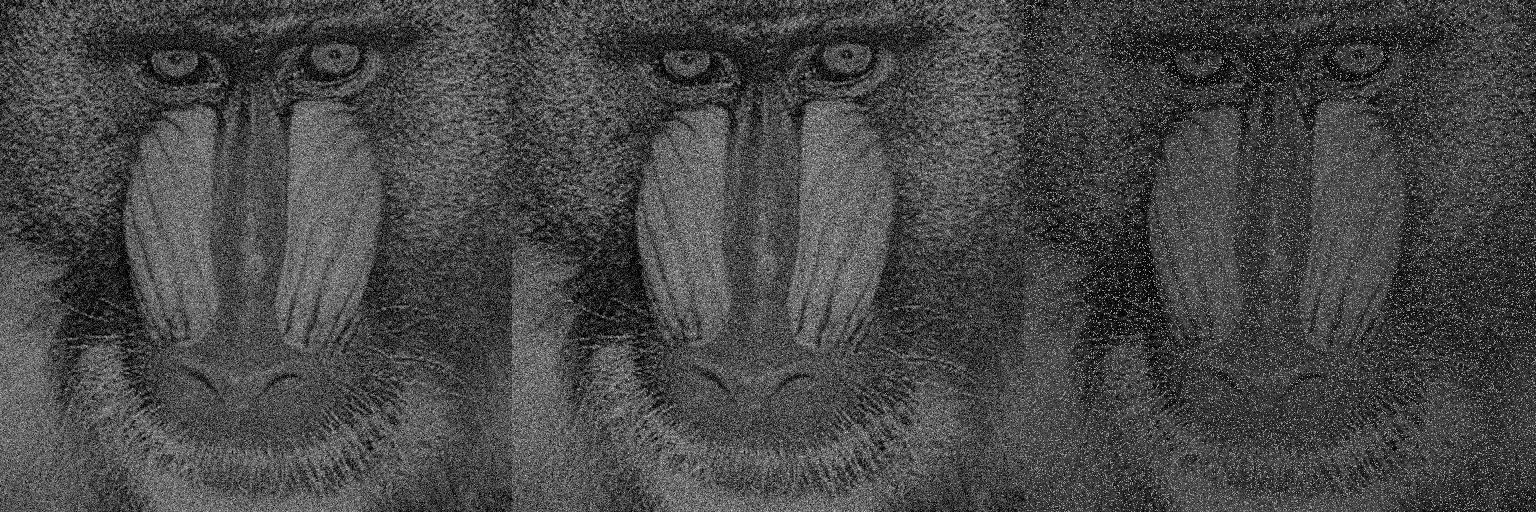

In [19]:
my_show([img_g img_p img_h])

In [21]:
function gaussian_noise_remove(arr; kernel_size=(3,3), σ=1)
	gauss = IndexFunArrays.normal(kernel_size, sigma=σ)
	normalized_gauss = gauss ./ sum(gauss)
	filtered_arr = imfilter(arr, normalized_gauss)
	return filtered_arr
end

gaussian_noise_remove (generic function with 1 method)

In [23]:
begin
	img_p_gauss = gaussian_noise_remove(img_p);
	img_g_gauss = gaussian_noise_remove(img_g);
	img_h_gauss = gaussian_noise_remove(img_h);
end;

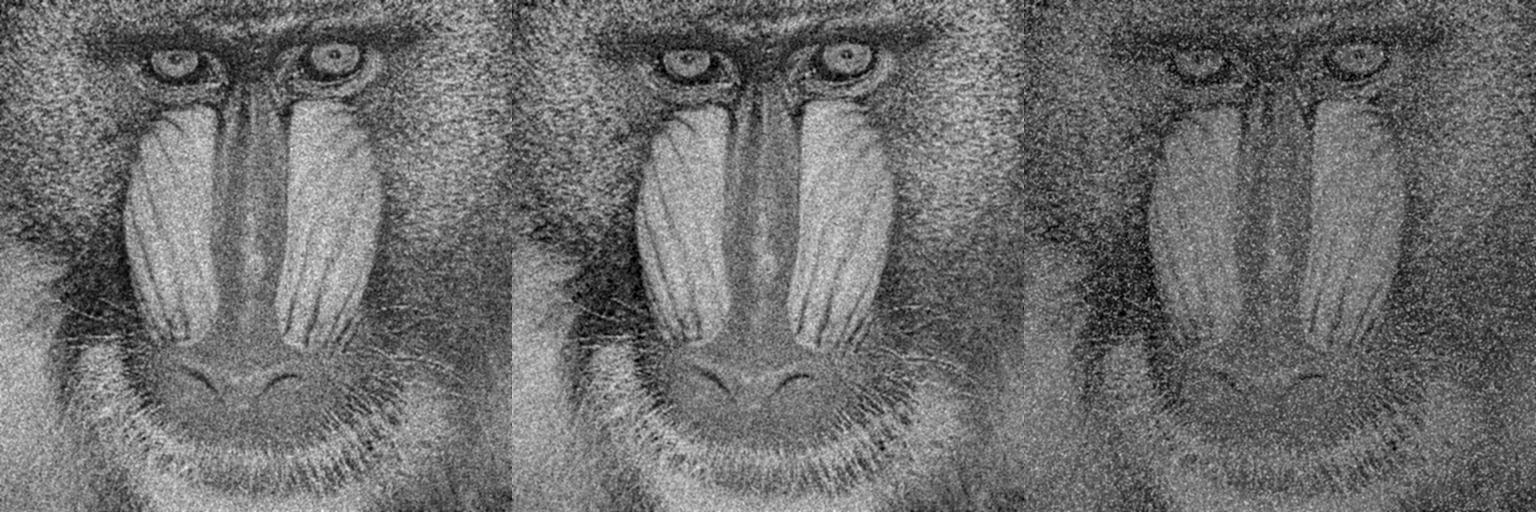

In [24]:
my_show([img_p_gauss img_g_gauss img_h_gauss])

## **Remove Noise With Median Filter**

The median filter slides with a quadratic shaped box over the array and always takes the median value of this array.

So conceptually, you can use two for loops over the first two dimensions of the array. Then extract a region around this point and calculate the median. Try to preserve the image output size. Assign the median to this pixel.

In [29]:
using Statistics

In [5]:
#=
function median_noise_remove!(arr; kernel_size=(5,5))
	filtered_arr = mapwindow(median, arr, kernel_size)
	return filtered_arr
end
=#

In [4]:
function median_noise_remove!(arr; kernel_size=(5,5))
	kx, ky = div(kernel_size[1], 2), div(kernel_size[2], 2)
	output = copy(arr)

	for i in 1:size(arr, 1)
		for j in 1: size(arr, 2)
			x_min = max(1, i - kx)
			x_max = min(size(arr, 1), i + kx)
			y_min = max(1, j -ky)
			y_max = min(size(arr,2), j + ky)

			window = arr[x_min:x_max, y_min:y_max]
			output[i,j] = median(window)
		end
	end
	arr .= output
	return arr
end

median_noise_remove! (generic function with 1 method)

This one is better than `mapwindow` because it avoids padding

In [6]:
begin
	img_p_median = median_noise_remove!(copy(img_p));
	img_g_median = median_noise_remove!(copy(img_g));
	img_h_median = median_noise_remove!(copy(img_h));
end;

UndefVarError: UndefVarError: `img_p` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

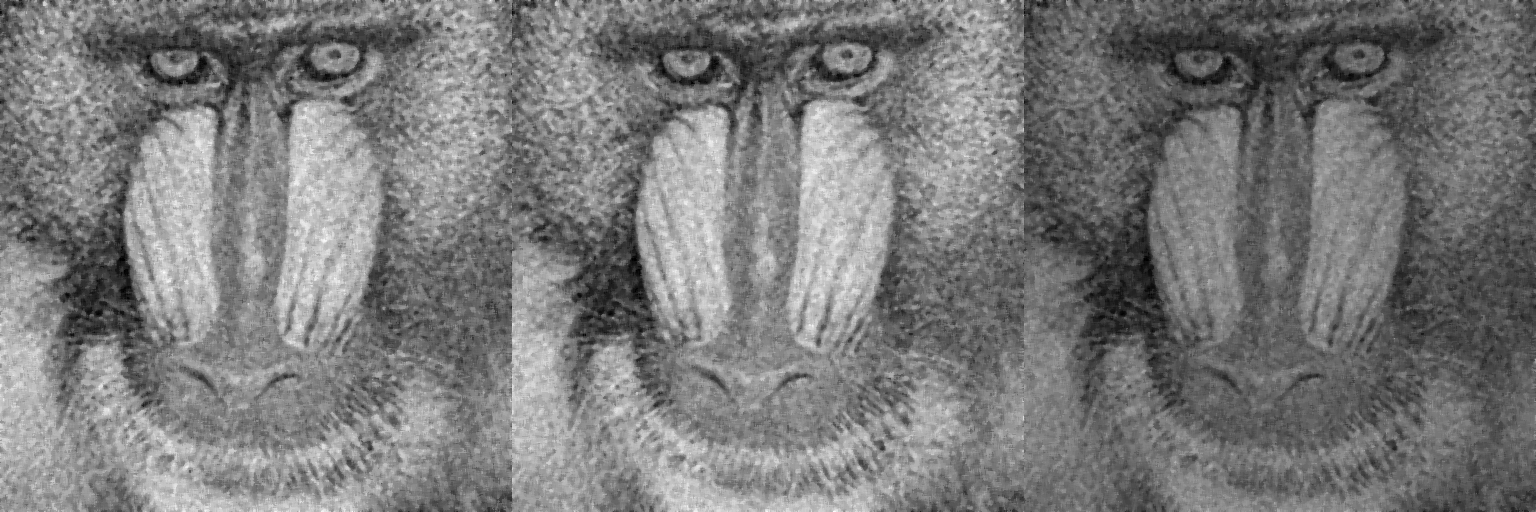

In [31]:
my_show([img_p_median img_g_median img_h_median])